In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"

In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
SLN_206_adata = sc.read(f"{save_path}/spleen_lymph_206.h5ad")
SLN_111_adata = sc.read(f"{save_path}/spleen_lymph_111.h5ad")

In [3]:
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in SLN_111_adata.uns["protein_names"]]
)
SLN_111_adata.obsm["protein_expression"] = SLN_111_adata.obsm["protein_expression"][
    :, keep_pro_111
]
SLN_111_adata.uns["protein_names"] = SLN_111_adata.uns["protein_names"][keep_pro_111]

In [4]:
keep_pro_206 = np.array(
    [not p.startswith("HTO") for p in SLN_206_adata.uns["protein_names"]]
)
SLN_206_adata.obsm["protein_expression"] = SLN_206_adata.obsm["protein_expression"][
    :, keep_pro_206
]
SLN_206_adata.uns["protein_names"] = SLN_206_adata.uns["protein_names"][keep_pro_206]

In [29]:
rna_data_111 = ad.AnnData(
    X=SLN_111_adata.X,
    obs=SLN_111_adata.obs,
    var=pd.DataFrame(index=SLN_111_adata.var.index),
)
rna_data_111.obs['n_counts']  = rna_data_111.X.sum(axis=1)
rna_data_111.obs['panel']  = '111'
rna_data_111.obs_names = 'p111_'+rna_data_111.obs_names

In [30]:
rna_data_206 = ad.AnnData(
    X=SLN_206_adata.X,
    obs=SLN_206_adata.obs,
    var=pd.DataFrame(index=SLN_206_adata.var.index),
)
rna_data_206.obs['n_counts']  = rna_data_206.X.sum(axis=1)
rna_data_206.obs['panel']  = '206'
rna_data_206.obs_names = 'p206_'+rna_data_206.obs_names

In [82]:
protein_data_111 = ad.AnnData(
    X=np.array(SLN_111_adata.obsm["protein_expression"]),
    obs=SLN_111_adata.obs.copy(),
    var=SLN_111_adata.uns["protein_names"].copy()
)
protein_data_111.var_names = SLN_111_adata.uns["protein_names"]
protein_data_111.var = protein_data_111.var.drop(columns=0)
protein_data_111.obs['n_counts']  = protein_data_111.X.sum(axis=1)
protein_data_111.obs['panel']  = '111'
protein_data_111.obs_names = 'p111_'+protein_data_111.obs_names

In [83]:
protein_data_206 = ad.AnnData(
    X=np.array(SLN_206_adata.obsm["protein_expression"]),
    obs=SLN_206_adata.obs.copy(),
    var=SLN_206_adata.uns["protein_names"].copy()
)
protein_data_206.var_names = SLN_206_adata.uns["protein_names"]
protein_data_206.var = protein_data_206.var.drop(columns=0)
protein_data_206.obs['n_counts']  = protein_data_206.X.sum(axis=1)
protein_data_206.obs['panel']  = '206'
protein_data_206.obs_names = 'p206_'+protein_data_206.obs_names

In [33]:
# merge the rna adata of the two datasets
rna_adata_pool = ad.concat([rna_data_111, rna_data_206], join="outer", axis=0)

In [34]:
protein_adata_pool = ad.concat([protein_data_111, protein_data_206], join="outer", axis=0)

In [85]:
protein_adata_intersect = ad.concat([protein_data_111, protein_data_206], join="inner", axis=0)
protein_adata_intersect 

AnnData object with n_obs × n_vars = 32648 × 110
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'

In [35]:
rna_adata_pool

AnnData object with n_obs × n_vars = 32648 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'

# Preprocess

In [86]:
mdata = mu.MuData({
    "rna": rna_adata_pool,
    "protein": protein_adata_intersect,
})

In [37]:
rna_adata_pool.var['mt'] = rna_adata_pool.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata_pool, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

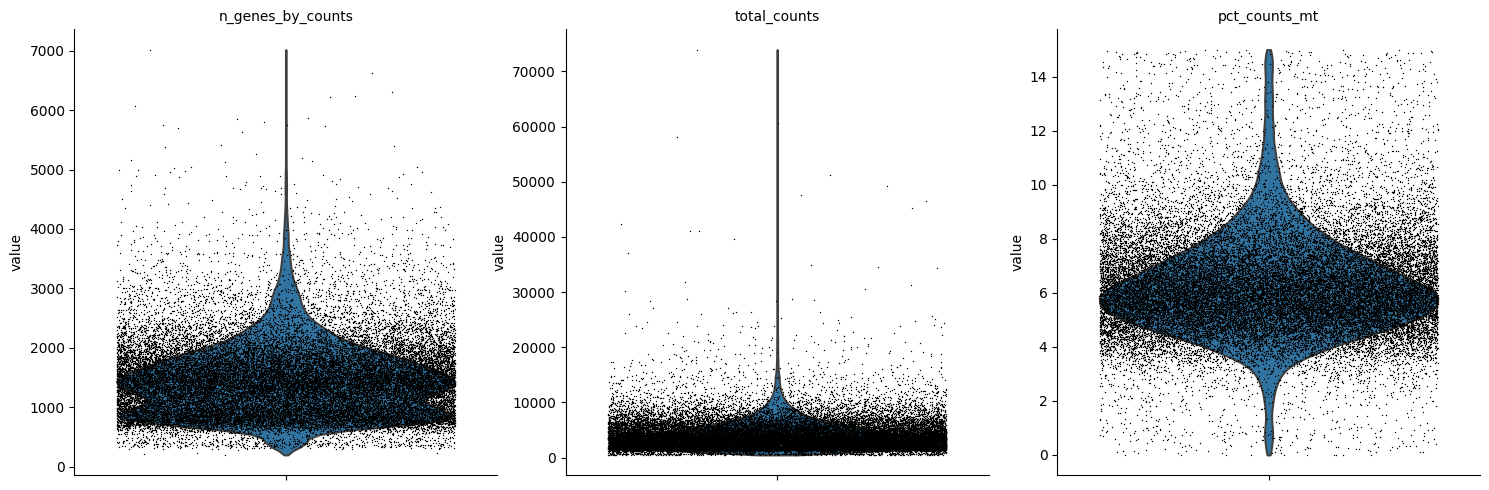

In [38]:
sc.pl.violin(rna_adata_pool, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [39]:
rna_adata_pool.layers["counts"] = rna_adata_pool.X.copy()

In [40]:
sc.pp.normalize_total(rna_adata_pool, target_sum=1e4)
sc.pp.log1p(rna_adata_pool)
rna_adata_pool.obs_names_make_unique()

In [41]:
sc.pp.highly_variable_genes(
    rna_adata_pool,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch_indices",
    layer="counts",
)

In [42]:
sc.tl.pca(rna_adata_pool, svd_solver='arpack')
sc.pp.neighbors(rna_adata_pool, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna_adata_pool, resolution=.75)
sc.tl.umap(rna_adata_pool, spread=1., min_dist=.5, random_state=42)

In [43]:
rna_adata_pool.write_h5ad(f"{save_path}/rna_pool.h5ad")

In [44]:
protein_adata_pool.layers["counts"] = protein_adata_pool.X.copy()
# sc.pp.normalize_total(protein_adata_pool, target_sum=1e4)
# sc.pp.log1p(protein_adata_pool)

In [45]:
protein_adata_pool.layers["counts"] = np.nan_to_num(protein_adata_pool.layers["counts"], nan=0.0)
protein_adata_pool.X = protein_adata_pool.layers["counts"].copy()
sc.pp.normalize_total(protein_adata_pool, target_sum=1e4)
sc.pp.log1p(protein_adata_pool)

In [46]:
protein_adata_pool.write_h5ad(f"{save_path}/protein_pool.h5ad")

In [87]:
# protein_adata_intersect.layers["counts"] = np.nan_to_num(protein_adata_intersect.layers["counts"], nan=0.0)
protein_adata_intersect.X = np.nan_to_num(protein_adata_intersect.X, nan=0.0)
sc.pp.normalize_total(protein_adata_intersect, target_sum=1e4)
sc.pp.log1p(protein_adata_intersect)

In [88]:
protein_adata_intersect.write(f"{save_path}/scCITE_intersect_protein.h5ad")
mdata.write_h5mu(f"{save_path}/scCITE_intersect.h5mu")

In [53]:
mdata.write_h5mu(f"{save_path}/scCITE_combine.h5mu")

# GraphCrossAttn

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import torch
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"
rna_adata_pool = ad.read_h5ad(f"{save_path}/rna_pool.h5ad")
# protein_adata_pool = ad.read_h5ad(f"{save_path}/protein_pool.h5ad")
protein_adata_intersect = ad.read_h5ad(f"{save_path}/scCITE_intersect_protein.h5ad")

## With highly variable

In [3]:
rna_adata_pool

AnnData object with n_obs × n_vars = 32648 × 13553
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
rna_adata_pool_subset = rna_adata_pool[:, rna_adata_pool.var["highly_variable"]]
rna_adata_pool_subset = rna_adata_pool_subset[:, 
        rna_adata_pool_subset.var.sort_values(by="highly_variable_rank").index]

In [5]:
highly_variable_names = rna_adata_pool_subset.var_names.to_list()
# df = pd.DataFrame(highly_variable_names)
# df.to_csv(f"{save_path}/scCITE_hvg.csv", index=False)

In [6]:
from dataset import create_graphData, split_data

num_splits = 1
num_val = 0.2
num_test = 0.2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

graph_data = create_graphData(rna_adata_pool_subset, protein_adata_intersect, device)
training_data = split_data(graph_data, num_splits=num_splits, num_val=num_val, num_test=num_test)

In [7]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_adata_pool_subset.X.shape[1]
prot_input_dim = protein_adata_intersect.X.shape[1]

hidden_dim = 256
embedding_dim = 256
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.7
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-4
epochs = 10
mask_ratio = 0.85

In [19]:
import importlib
import sys

importlib.reload(sys.modules['train'])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [8]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice,
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
    GAT_encoding=True,
)

trainer.train(plot_loss=False)

Epoch 1/10 train_loss: 110.77532 val_loss: 13.58606
Epoch 2/10 train_loss: 33.30305 val_loss: 10.09000
Epoch 3/10 train_loss: 28.17042 val_loss: 9.07784
Epoch 4/10 train_loss: 25.01653 val_loss: 8.07212
Epoch 5/10 train_loss: 22.47711 val_loss: 7.28946
Epoch 6/10 train_loss: 20.31109 val_loss: 6.60425
Epoch 7/10 train_loss: 18.42849 val_loss: 6.02712
Epoch 8/10 train_loss: 16.82386 val_loss: 5.51346
Epoch 9/10 train_loss: 15.35776 val_loss: 5.04123
Epoch 10/10 train_loss: 14.10591 val_loss: 4.67403
Best model saved at split 0


In [94]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_intersect_hvg.pt")

In [9]:
mudata = mu.MuData({
    "rna": rna_adata_pool,
    "prot": protein_adata_intersect,
})

In [10]:
mudata.obsm["GCAT_embedding"] = trainer.get_embedding(graph_data)

In [11]:
# Clustering based on the embedding
sc.pp.neighbors(mudata, use_rep="GCAT_embedding", key_added="GCAT_neighbors")
sc.tl.umap(mudata, random_state=1, neighbors_key="GCAT_neighbors")

In [12]:
sc.pp.neighbors(mudata['prot'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [13]:
mu.pp.intersect_obs(mudata)

In [14]:
mudata

MuData object with n_obs × n_vars = 32648 × 13663
  uns:	'GCAT_neighbors', 'umap'
  obsm:	'GCAT_embedding', 'X_umap'
  obsp:	'GCAT_neighbors_distances', 'GCAT_neighbors_connectivities'
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    prot:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p', 'neighbors'
      obsm:	'X_pca'
      obsp:	'distances', 'connectivities'

In [15]:
# mu.tl.louvain(mudata, resolution=[2, .1], random_state=1)
mu.tl.leiden(mudata, resolution=2, random_state=1, 
            neighbors_key='neighbors', key_added="leiden")

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


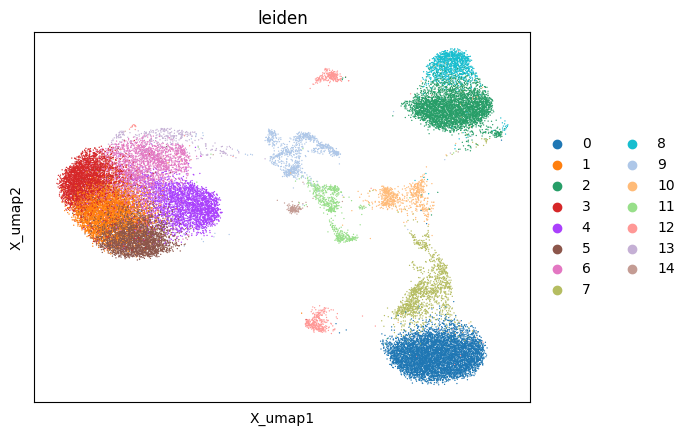

In [16]:
# mu.pl.umap(mudata, frameon=False, 
#             color=['batch_indices', 'panel', 'leiden'],)
mu.pl.embedding(mudata, basis="X_umap", 
                color=['leiden'])

In [38]:
mudata['rna'].obsm["GCAT_umap"] = mudata.obsm["X_umap"]

In [45]:
reassign_cluster_names = {
    "Neutrophils": "Neutrophils",
    "Plasma B": "Plasma B",
    "Red-pulp macrophages": "Macrophage",
    "T doublets": "doublets",
    "Transitional B": "Transitional B",
    "Tregs": "Treg",
    "cDC1s": "DC",
    "cDC2s": "DC",
    "pDCs": "DC",
    "B doublets": "doublets",
    "B-CD4 T cell doublets": "doublets",
    "B-CD8 T cell doublets": "doublets",
    "B-macrophage doublets": "doublets",
    "B1 B": "B1 B",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Cycling B/T cells": "Cycling B/T cells",
    "Erythrocytes": "Erythrocyte",
    "GD T": "GD T",
    "ICOS-high Tregs": "Treg",
    "Activated CD4 T": "CD4 T",
    "Ifit3-high B": "Ifit3-high B",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Low quality B cells": "Low quality B",
    "Low quality T cells": "Low quality T",
    "Ly6-high mono": "Monocyte",
    "Ly6-low mono": "Monocyte",
    "MZ B": "MZ B",
    "MZ/Marco-high macrophages": "Macrophage",
    "Mature B": "Mature B",
    "Migratory DCs": "DC",
    "NK": "NK",
    "NKT": "NKT",
}
mudata['rna'].obs['Lcelltype'] = mudata['rna'].obs['cell_types'].map(reassign_cluster_names).astype('category')

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


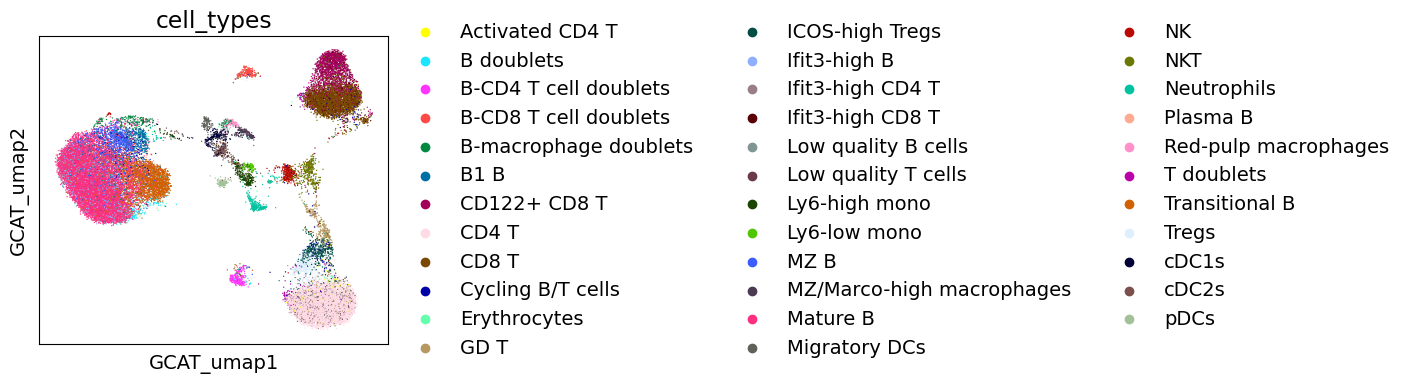

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


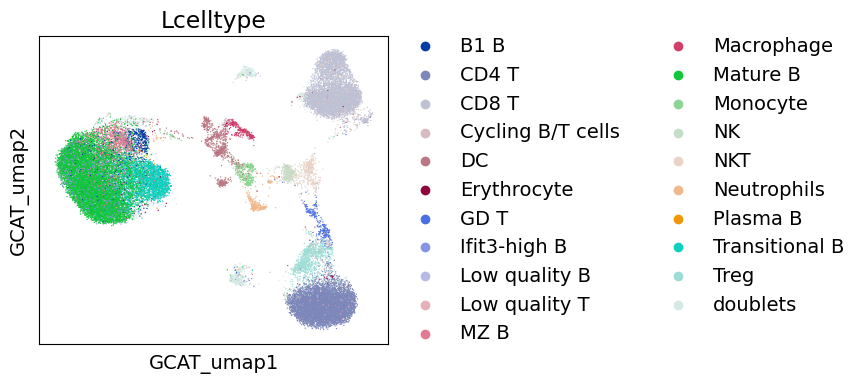

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


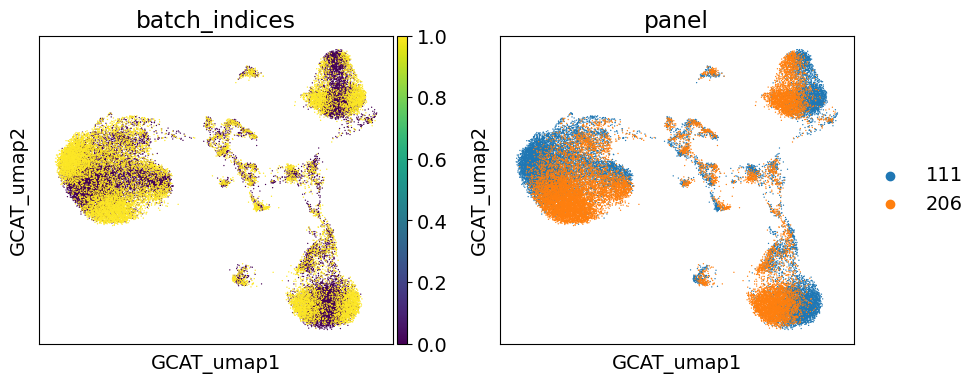

In [49]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (4.5,4)
plt.rcParams.update({'font.size': 14}) #设定全局字体大小
sc.pl.embedding(mudata['rna'], basis="GCAT_umap", color=["cell_types"])
sc.pl.embedding(mudata['rna'], basis="GCAT_umap", color=["Lcelltype"], cmap="Set3")
sc.pl.embedding(mudata['rna'], basis="GCAT_umap", color=["batch_indices", "panel"])

In [ ]:
# mudata['rna'].obs['Lcelltype'] = mudata['rna'].obs['Lcelltype'].cat.reorder_categories(['B', 'CD4 T','Treg','GD T', 'CD8 T','NKT','NK', 
#                                                                          'Low quality B','Low quality T',
#                                                                          'Monocyte','Macrophage','DC','Neutrophil', 
#                                                                          'Erythrocyte','doublets'])

In [38]:
# np.save("../data/GraphCrossRNArecon_intersect_hvg_SLN_scCITE.npy", rna_recon)
# np.save("../data/GraphCrossPorteinrecon_intersect_hvg_SLN_scCITE.npy", prot_recon)

In [39]:
# np.save("../data/GraphCrossEmbedding_intersect_hvg_SLN_scCITE.npy", embedding)

In [18]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [19]:
reducer = umap.UMAP(random_state=42)
# UMAP_embedding = reducer.fit_transform(embedding.cpu().numpy())

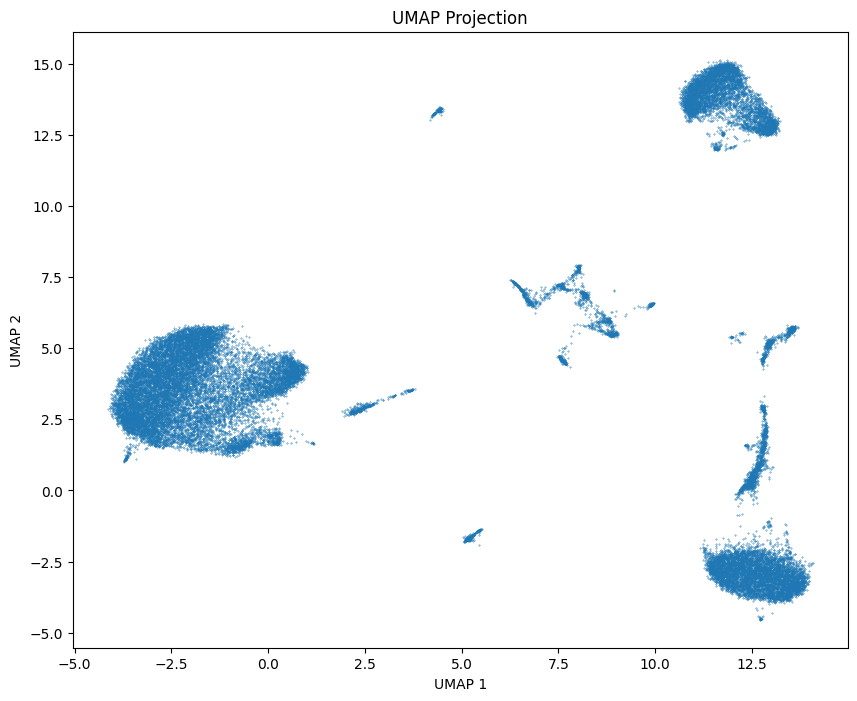

In [42]:
plt.figure(figsize=(10, 8))
plt.scatter(
    UMAP_embedding[:, 0], UMAP_embedding[:, 1], s=0.1
    )
plt.title("UMAP Projection")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

Epoch 1/10 train_loss: 218.26448 val_loss: 24.79281
Epoch 2/10 train_loss: 57.71772 val_loss: 17.36521
Epoch 3/10 train_loss: 47.34075 val_loss: 15.11485
Epoch 4/10 train_loss: 41.32517 val_loss: 13.30199
Epoch 5/10 train_loss: 36.07458 val_loss: 11.32153
Epoch 6/10 train_loss: 30.21574 val_loss: 9.46736
Epoch 7/10 train_loss: 25.18750 val_loss: 7.96529
Epoch 8/10 train_loss: 21.01488 val_loss: 6.67820
Epoch 9/10 train_loss: 17.65793 val_loss: 5.66735
Epoch 10/10 train_loss: 15.09619 val_loss: 4.91989
Best model saved at split 0


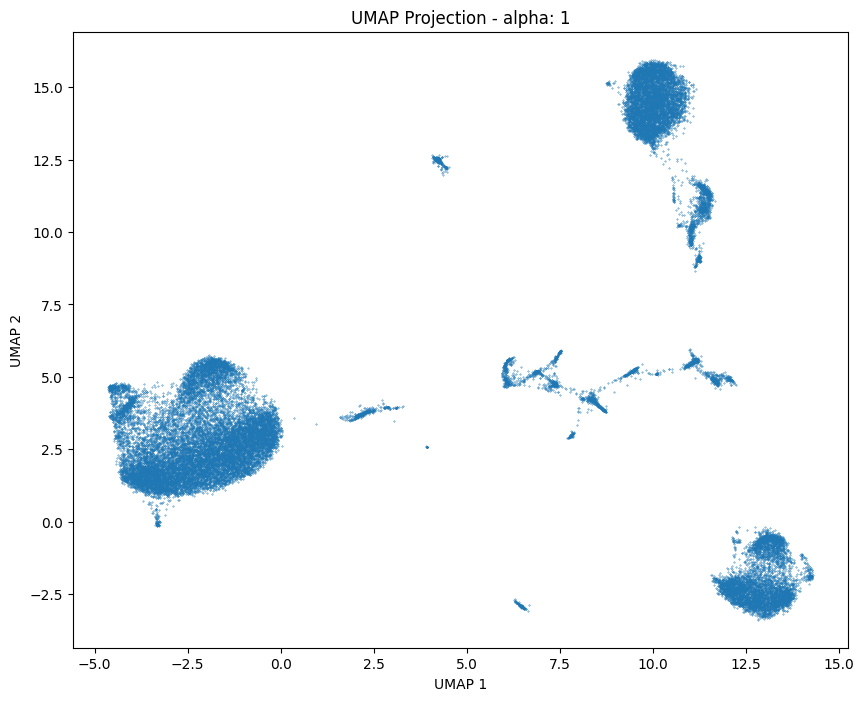

Epoch 1/10 train_loss: 204.57641 val_loss: 22.71462
Epoch 2/10 train_loss: 53.99597 val_loss: 16.04632
Epoch 3/10 train_loss: 43.92082 val_loss: 13.99574
Epoch 4/10 train_loss: 38.27581 val_loss: 12.32193
Epoch 5/10 train_loss: 33.33099 val_loss: 10.49307
Epoch 6/10 train_loss: 28.09739 val_loss: 8.85278
Epoch 7/10 train_loss: 23.64646 val_loss: 7.50302
Epoch 8/10 train_loss: 19.99487 val_loss: 6.39198
Epoch 9/10 train_loss: 17.02322 val_loss: 5.50160
Epoch 10/10 train_loss: 14.73771 val_loss: 4.80225
Best model saved at split 0


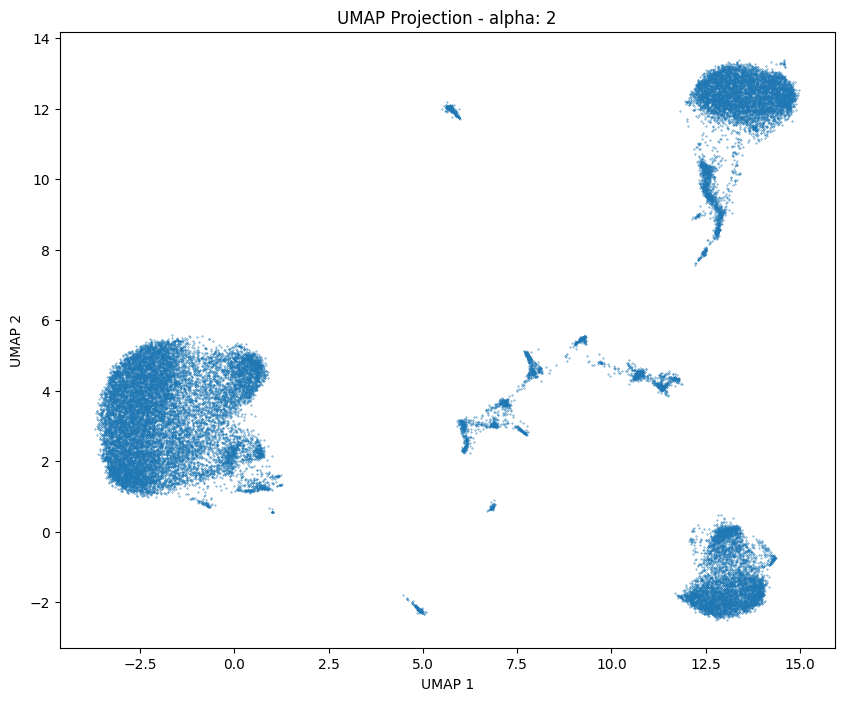

Epoch 1/10 train_loss: 176.09328 val_loss: 20.60535
Epoch 2/10 train_loss: 49.11005 val_loss: 14.66317
Epoch 3/10 train_loss: 40.91897 val_loss: 13.18035
Epoch 4/10 train_loss: 35.68696 val_loss: 11.42444
Epoch 5/10 train_loss: 31.18562 val_loss: 9.90098
Epoch 6/10 train_loss: 26.51239 val_loss: 8.36529
Epoch 7/10 train_loss: 22.41387 val_loss: 7.09142
Epoch 8/10 train_loss: 19.04711 val_loss: 6.06762
Epoch 9/10 train_loss: 16.32636 val_loss: 5.24477
Epoch 10/10 train_loss: 14.24684 val_loss: 4.62223
Best model saved at split 0


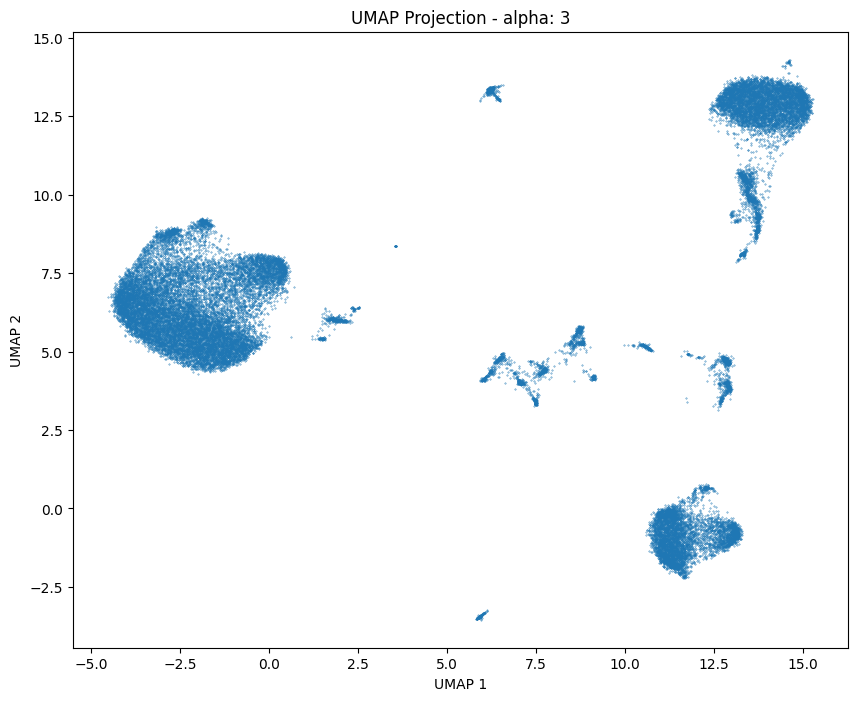

Epoch 1/10 train_loss: 156.99423 val_loss: 18.40926
Epoch 2/10 train_loss: 44.50098 val_loss: 13.07906
Epoch 3/10 train_loss: 36.33560 val_loss: 11.62370
Epoch 4/10 train_loss: 31.89255 val_loss: 10.25631
Epoch 5/10 train_loss: 28.09089 val_loss: 8.97396
Epoch 6/10 train_loss: 24.37330 val_loss: 7.76350
Epoch 7/10 train_loss: 21.11448 val_loss: 6.74636
Epoch 8/10 train_loss: 18.42509 val_loss: 5.94457
Epoch 9/10 train_loss: 16.28872 val_loss: 5.29845
Epoch 10/10 train_loss: 14.50568 val_loss: 4.75865
Best model saved at split 0


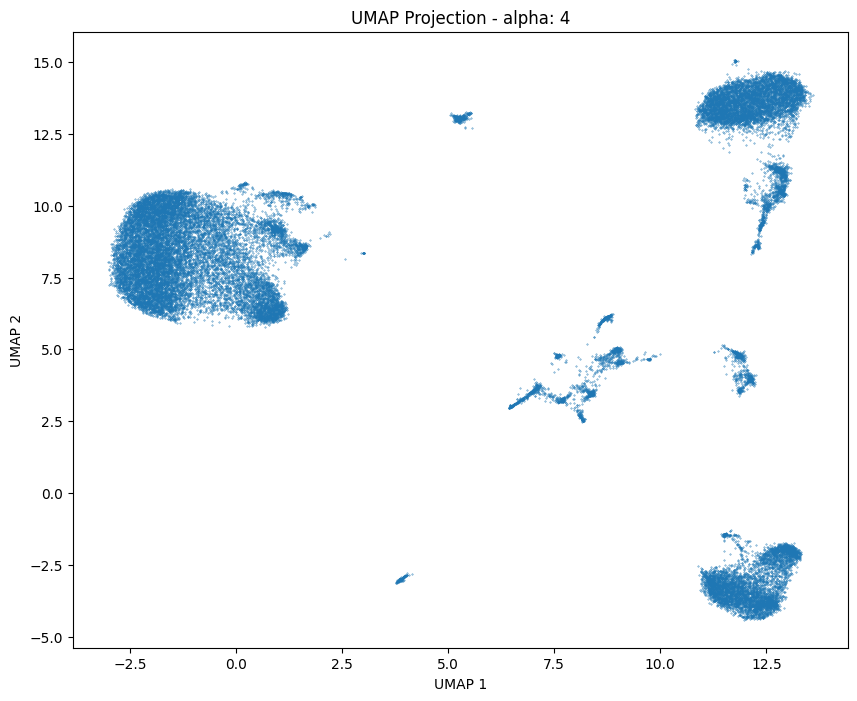

Epoch 1/10 train_loss: 135.38035 val_loss: 15.90724
Epoch 2/10 train_loss: 38.57661 val_loss: 11.57956
Epoch 3/10 train_loss: 32.23481 val_loss: 10.34134
Epoch 4/10 train_loss: 28.37983 val_loss: 9.12250
Epoch 5/10 train_loss: 25.15235 val_loss: 8.09497
Epoch 6/10 train_loss: 22.30815 val_loss: 7.19780
Epoch 7/10 train_loss: 19.78363 val_loss: 6.41166
Epoch 8/10 train_loss: 17.58175 val_loss: 5.71346
Epoch 9/10 train_loss: 15.72550 val_loss: 5.16319
Epoch 10/10 train_loss: 14.17037 val_loss: 4.67344
Best model saved at split 0


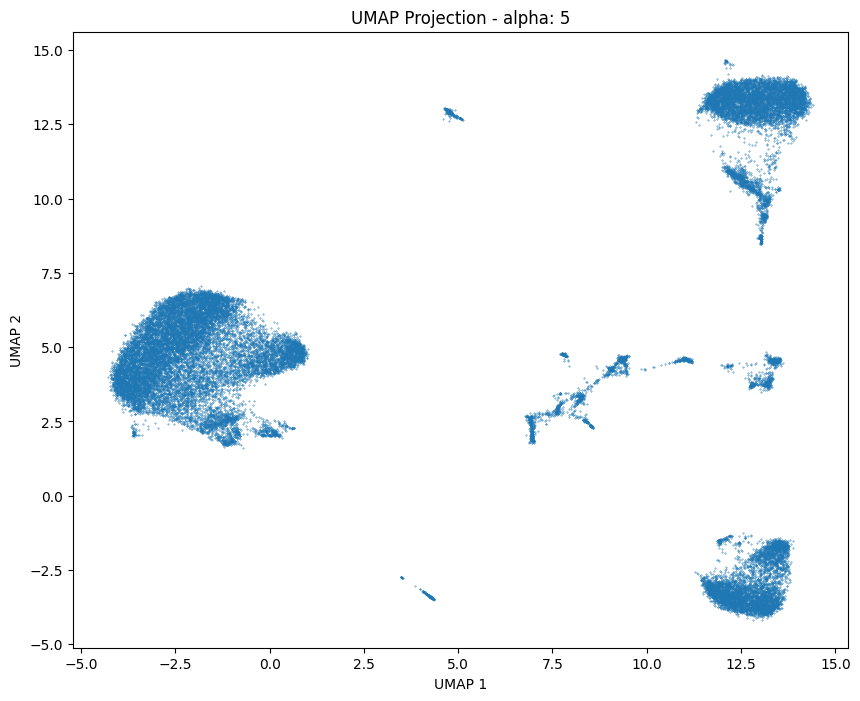

Epoch 1/10 train_loss: 109.72149 val_loss: 13.49278
Epoch 2/10 train_loss: 33.02745 val_loss: 10.04164
Epoch 3/10 train_loss: 27.88855 val_loss: 8.94982
Epoch 4/10 train_loss: 24.91348 val_loss: 8.12903
Epoch 5/10 train_loss: 22.66513 val_loss: 7.36086
Epoch 6/10 train_loss: 20.54440 val_loss: 6.67423
Epoch 7/10 train_loss: 18.53279 val_loss: 6.00851
Epoch 8/10 train_loss: 16.75118 val_loss: 5.47428
Epoch 9/10 train_loss: 15.29793 val_loss: 5.03540
Epoch 10/10 train_loss: 14.09090 val_loss: 4.66936
Best model saved at split 0


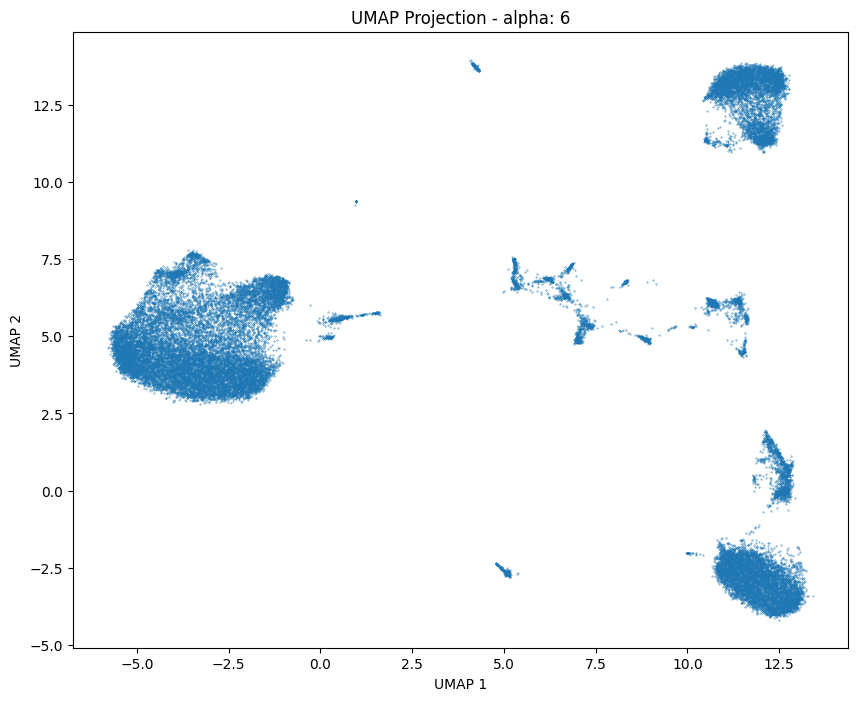

Epoch 1/10 train_loss: 85.86122 val_loss: 11.31258
Epoch 2/10 train_loss: 28.04699 val_loss: 8.53781
Epoch 3/10 train_loss: 23.90371 val_loss: 7.73132
Epoch 4/10 train_loss: 21.56874 val_loss: 7.06579
Epoch 5/10 train_loss: 19.90276 val_loss: 6.52444
Epoch 6/10 train_loss: 18.37126 val_loss: 6.03070
Epoch 7/10 train_loss: 16.95950 val_loss: 5.54482
Epoch 8/10 train_loss: 15.62415 val_loss: 5.13262
Epoch 9/10 train_loss: 14.46352 val_loss: 4.77013
Epoch 10/10 train_loss: 13.52636 val_loss: 4.48513
Best model saved at split 0


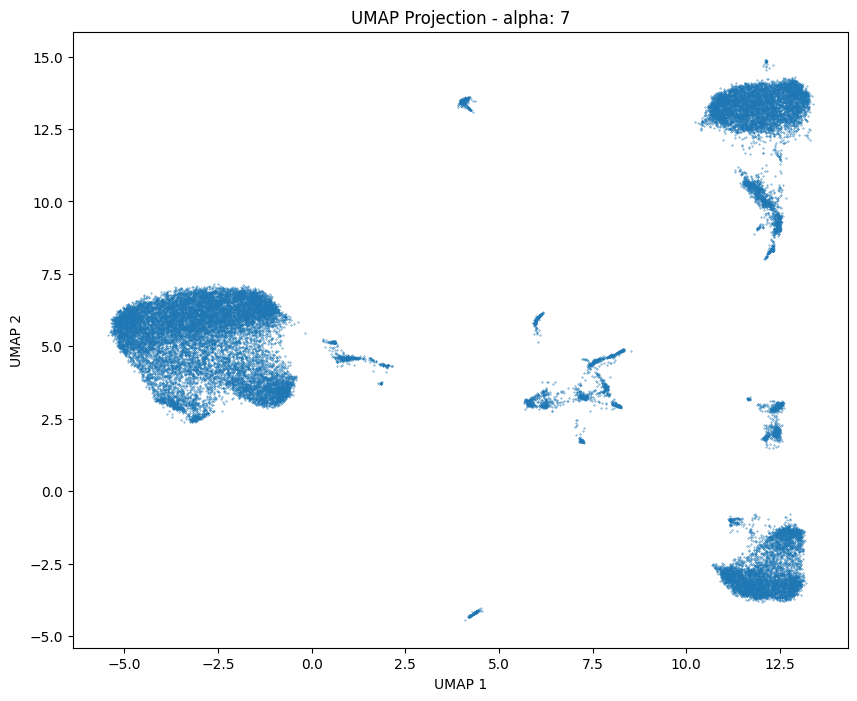

Epoch 1/10 train_loss: 64.92640 val_loss: 8.87276
Epoch 2/10 train_loss: 22.69952 val_loss: 6.97334
Epoch 3/10 train_loss: 19.66410 val_loss: 6.44678
Epoch 4/10 train_loss: 18.10867 val_loss: 5.96834
Epoch 5/10 train_loss: 17.03764 val_loss: 5.64592
Epoch 6/10 train_loss: 16.11395 val_loss: 5.33083
Epoch 7/10 train_loss: 15.25063 val_loss: 5.05446
Epoch 8/10 train_loss: 14.47052 val_loss: 4.79861
Epoch 9/10 train_loss: 13.77307 val_loss: 4.57762
Epoch 10/10 train_loss: 13.15646 val_loss: 4.38545
Best model saved at split 0


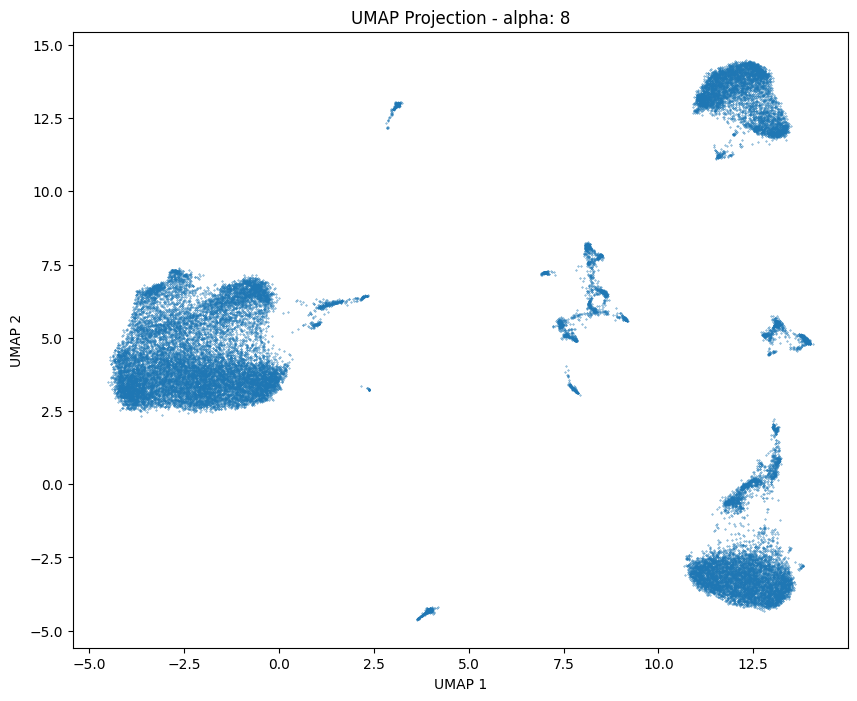

Epoch 1/10 train_loss: 43.12425 val_loss: 6.63249
Epoch 2/10 train_loss: 17.71299 val_loss: 5.47932
Epoch 3/10 train_loss: 15.58313 val_loss: 5.17516
Epoch 4/10 train_loss: 14.77554 val_loss: 4.87798
Epoch 5/10 train_loss: 14.13442 val_loss: 4.71590
Epoch 6/10 train_loss: 13.71010 val_loss: 4.58790
Epoch 7/10 train_loss: 13.34677 val_loss: 4.47022
Epoch 8/10 train_loss: 13.01614 val_loss: 4.35919
Epoch 9/10 train_loss: 12.68178 val_loss: 4.24721
Epoch 10/10 train_loss: 12.35881 val_loss: 4.14750
Best model saved at split 0


In [24]:
# check the umap visualization when alpha=0.1 to alpha=0.9
for alpha in range(1, 10, 1):
    trainer = Trainer( 
        training_data,
        model_choice=model_choice,
        rna_input_dim=rna_input_dim,
        prot_input_dim=prot_input_dim,
        hidden_dim=hidden_dim,
        embedding_dim=embedding_dim,
        heads=heads,
        num_blocks=num_blocks,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        mask_ratio=mask_ratio,
        permute=False,
        preserve_rate=preserve_rate,
        num_splits=num_splits,
        device=device,
        alpha=alpha/10,
        beta=beta,
    )
    trainer.train(plot_loss=False)
    embedding = trainer.get_embedding(graph_data)
    UMAP_embedding = reducer.fit_transform(embedding)
    plt.figure(figsize=(10, 8))
    plt.scatter(
        UMAP_embedding[:, 0], UMAP_embedding[:, 1], s=0.1
        )
    plt.title(f"UMAP Projection - alpha: {alpha}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

Epoch 1/10 train_loss: 87.44091 val_loss: 11.28542
Epoch 2/10 train_loss: 28.54558 val_loss: 8.54447
Epoch 3/10 train_loss: 24.14695 val_loss: 7.90638
Epoch 4/10 train_loss: 22.11028 val_loss: 7.29801
Epoch 5/10 train_loss: 20.57345 val_loss: 6.78305
Epoch 6/10 train_loss: 19.21484 val_loss: 6.32693
Epoch 7/10 train_loss: 17.96343 val_loss: 5.93167
Epoch 8/10 train_loss: 16.83778 val_loss: 5.58148
Epoch 9/10 train_loss: 15.90567 val_loss: 5.30359
Epoch 10/10 train_loss: 15.01359 val_loss: 5.00097
Best model saved at split 0


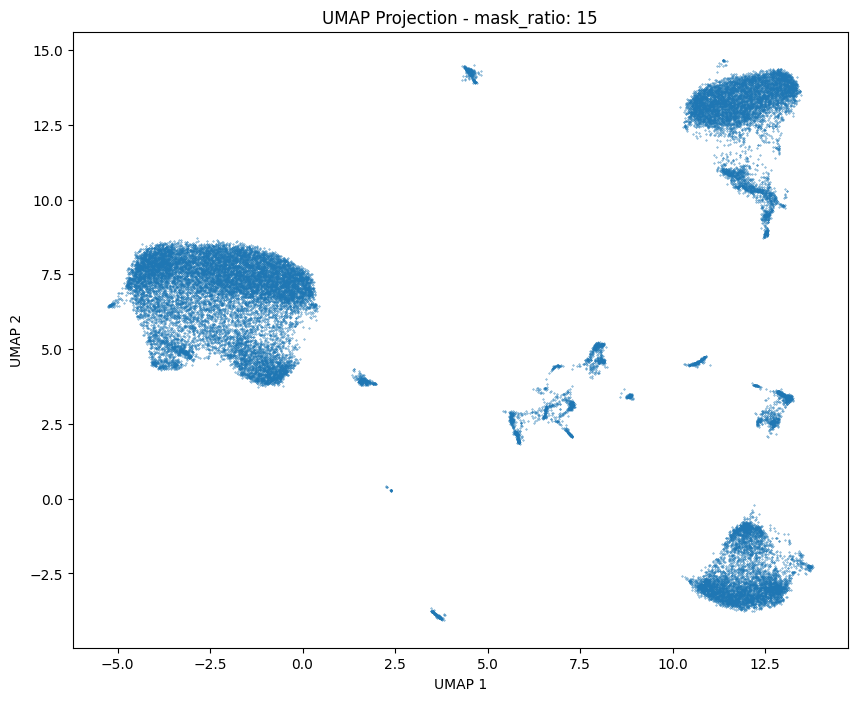

Epoch 1/10 train_loss: 87.89210 val_loss: 11.06499
Epoch 2/10 train_loss: 27.69684 val_loss: 8.54852
Epoch 3/10 train_loss: 24.20534 val_loss: 7.95720
Epoch 4/10 train_loss: 22.08743 val_loss: 7.17441
Epoch 5/10 train_loss: 20.29348 val_loss: 6.67754
Epoch 6/10 train_loss: 18.86580 val_loss: 6.20049
Epoch 7/10 train_loss: 17.60344 val_loss: 5.82460
Epoch 8/10 train_loss: 16.46170 val_loss: 5.44460
Epoch 9/10 train_loss: 15.42668 val_loss: 5.11498
Epoch 10/10 train_loss: 14.54806 val_loss: 4.84373
Best model saved at split 0


Epoch 1/10 train_loss: 88.66403 val_loss: 11.09195
Epoch 2/10 train_loss: 27.59968 val_loss: 8.56866
Epoch 3/10 train_loss: 24.09193 val_loss: 7.86773
Epoch 4/10 train_loss: 21.84652 val_loss: 7.12553
Epoch 5/10 train_loss: 20.22091 val_loss: 6.65031
Epoch 6/10 train_loss: 18.82318 val_loss: 6.21153
Epoch 7/10 train_loss: 17.53861 val_loss: 5.79664
Epoch 8/10 train_loss: 16.39161 val_loss: 5.42419
Epoch 9/10 train_loss: 15.37917 val_loss: 5.09424
Epoch 10/10 train_loss: 14.44636 val_loss: 4.82038
Best model saved at split 0


Epoch 1/10 train_loss: 89.47655 val_loss: 11.52668
Epoch 2/10 train_loss: 29.30027 val_loss: 8.62130
Epoch 3/10 train_loss: 24.13730 val_loss: 7.84423
Epoch 4/10 train_loss: 21.94527 val_loss: 7.20134
Epoch 5/10 train_loss: 20.38989 val_loss: 6.71856
Epoch 6/10 train_loss: 19.05170 val_loss: 6.27671
Epoch 7/10 train_loss: 17.73055 val_loss: 5.84773
Epoch 8/10 train_loss: 16.54650 val_loss: 5.45147
Epoch 9/10 train_loss: 15.47838 val_loss: 5.14248
Epoch 10/10 train_loss: 14.54668 val_loss: 4.83800
Best model saved at split 0


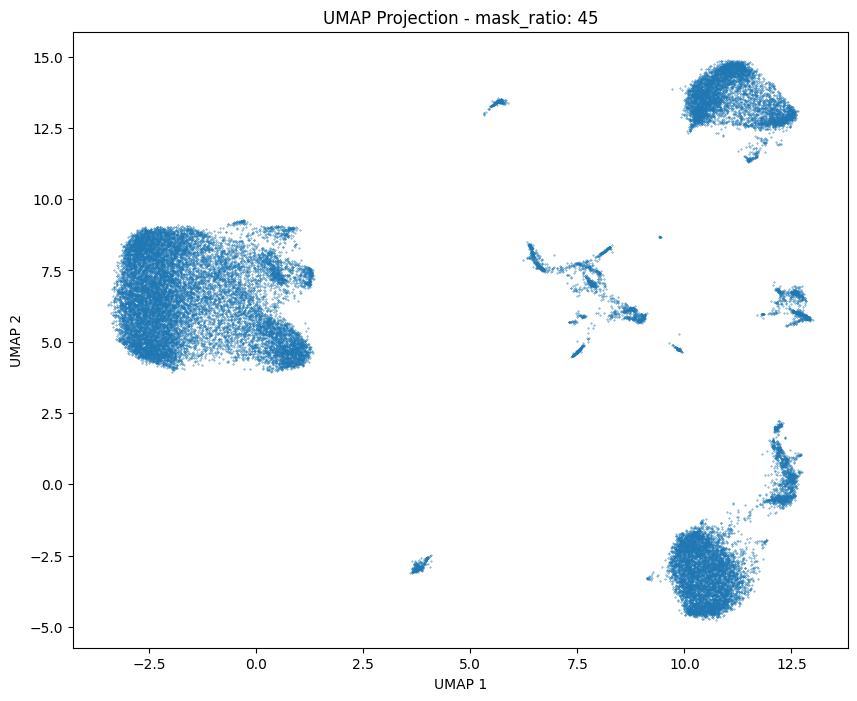

Epoch 1/10 train_loss: 87.58856 val_loss: 11.03680
Epoch 2/10 train_loss: 27.56195 val_loss: 8.49626
Epoch 3/10 train_loss: 23.86165 val_loss: 7.78165
Epoch 4/10 train_loss: 21.57236 val_loss: 7.02768
Epoch 5/10 train_loss: 19.80264 val_loss: 6.51077
Epoch 6/10 train_loss: 18.39483 val_loss: 6.04936
Epoch 7/10 train_loss: 17.09670 val_loss: 5.62775
Epoch 8/10 train_loss: 15.91129 val_loss: 5.23732
Epoch 9/10 train_loss: 14.89031 val_loss: 4.92938
Epoch 10/10 train_loss: 13.99944 val_loss: 4.64980
Best model saved at split 0


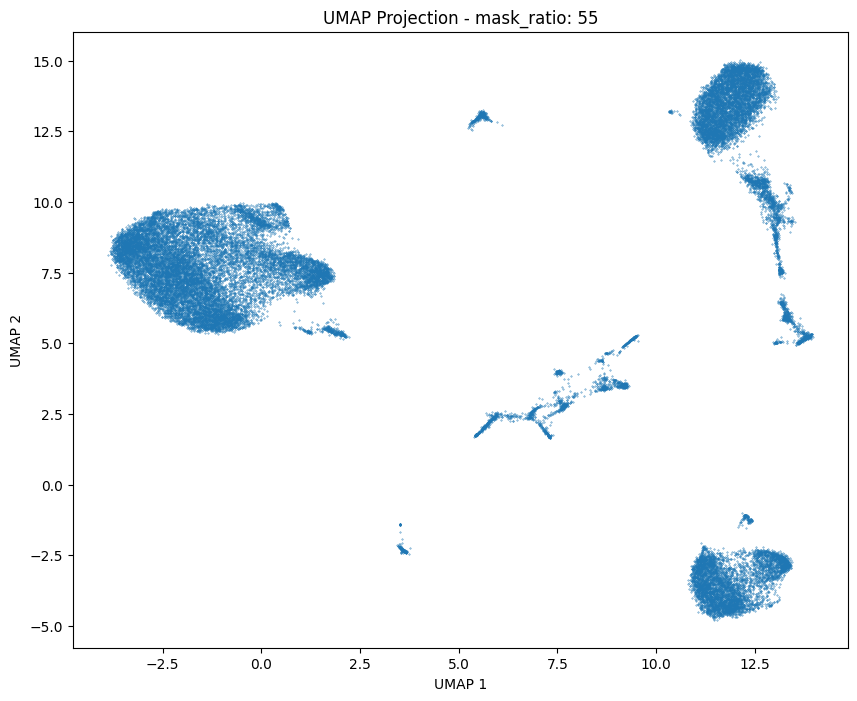

Epoch 1/10 train_loss: 87.46063 val_loss: 11.00564
Epoch 2/10 train_loss: 27.57323 val_loss: 8.53474
Epoch 3/10 train_loss: 23.79134 val_loss: 7.68052
Epoch 4/10 train_loss: 21.55777 val_loss: 7.09955
Epoch 5/10 train_loss: 19.99214 val_loss: 6.56739
Epoch 6/10 train_loss: 18.58032 val_loss: 6.11602
Epoch 7/10 train_loss: 17.27034 val_loss: 5.69034
Epoch 8/10 train_loss: 16.09803 val_loss: 5.30092
Epoch 9/10 train_loss: 15.04313 val_loss: 4.98162
Epoch 10/10 train_loss: 14.14087 val_loss: 4.69768
Best model saved at split 0


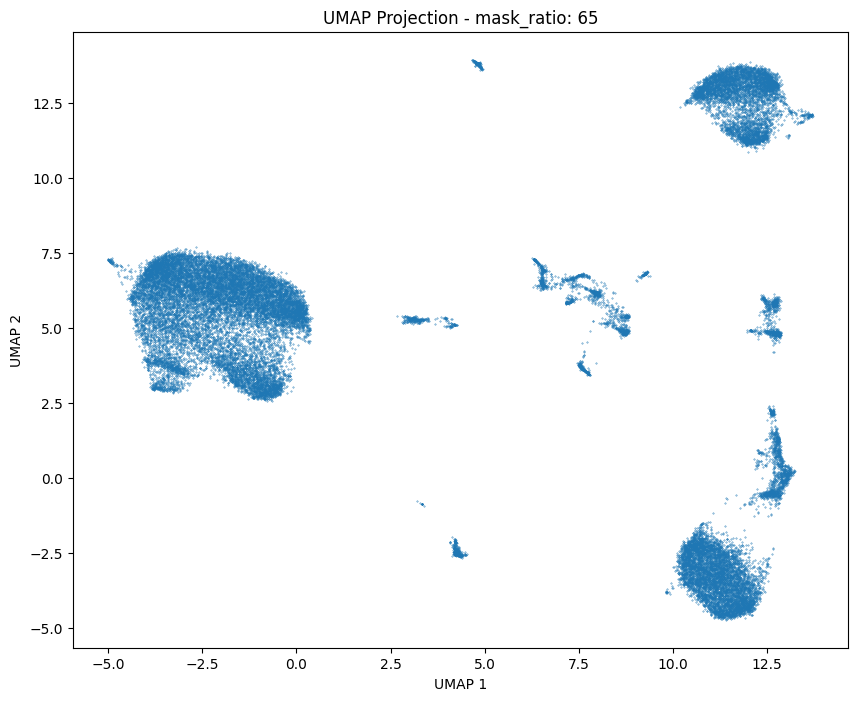

Epoch 1/10 train_loss: 88.61121 val_loss: 11.06372
Epoch 2/10 train_loss: 27.53326 val_loss: 8.51823
Epoch 3/10 train_loss: 23.86419 val_loss: 7.71187
Epoch 4/10 train_loss: 21.56092 val_loss: 7.07489
Epoch 5/10 train_loss: 20.02542 val_loss: 6.55617
Epoch 6/10 train_loss: 18.49342 val_loss: 6.05171
Epoch 7/10 train_loss: 17.07664 val_loss: 5.61106
Epoch 8/10 train_loss: 15.87193 val_loss: 5.24398
Epoch 9/10 train_loss: 14.86089 val_loss: 4.91648
Epoch 10/10 train_loss: 13.97363 val_loss: 4.64135
Best model saved at split 0


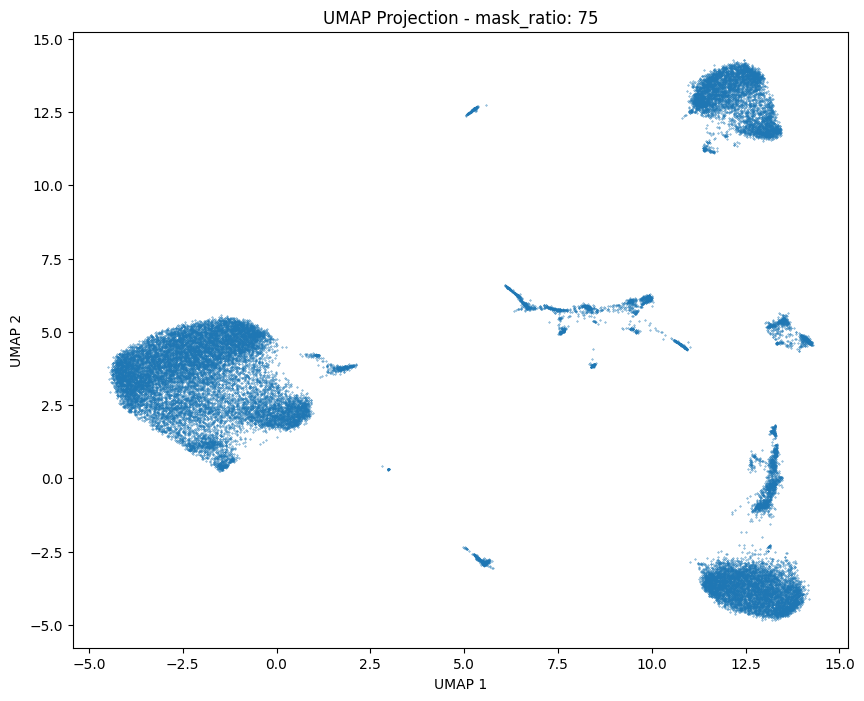

Epoch 1/10 train_loss: 85.08533 val_loss: 11.23043
Epoch 2/10 train_loss: 28.04796 val_loss: 8.58624
Epoch 3/10 train_loss: 24.31194 val_loss: 7.98235
Epoch 4/10 train_loss: 22.19616 val_loss: 7.24551
Epoch 5/10 train_loss: 20.39832 val_loss: 6.68043
Epoch 6/10 train_loss: 18.85301 val_loss: 6.16682
Epoch 7/10 train_loss: 17.35967 val_loss: 5.68319
Epoch 8/10 train_loss: 16.05158 val_loss: 5.28502
Epoch 9/10 train_loss: 14.92030 val_loss: 4.92069
Epoch 10/10 train_loss: 13.96910 val_loss: 4.64575
Best model saved at split 0


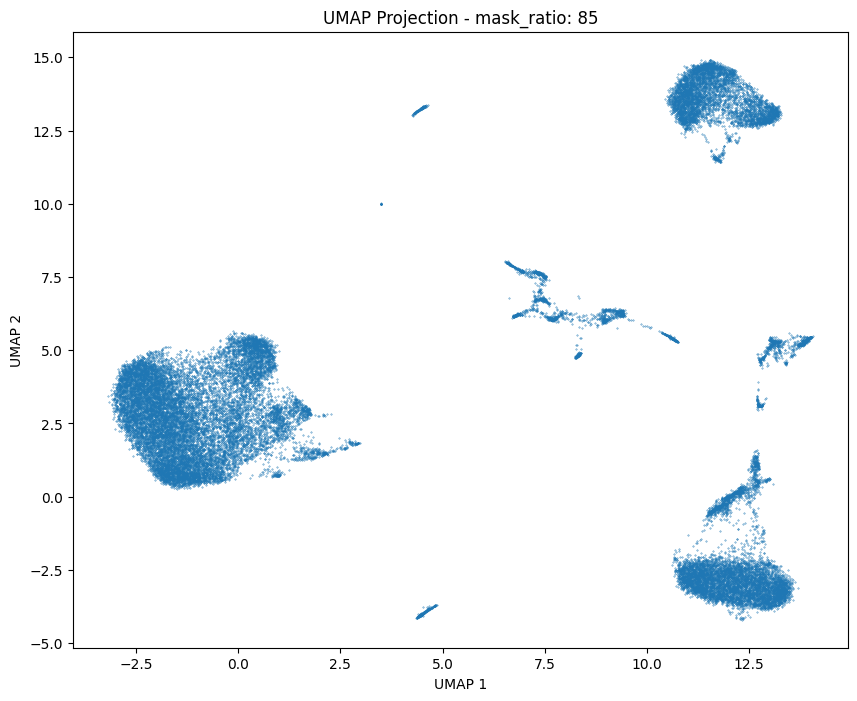

Epoch 1/10 train_loss: 88.05579 val_loss: 11.26479
Epoch 2/10 train_loss: 28.37007 val_loss: 8.53307
Epoch 3/10 train_loss: 23.98620 val_loss: 7.78649
Epoch 4/10 train_loss: 21.71781 val_loss: 7.07553
Epoch 5/10 train_loss: 19.94007 val_loss: 6.53773
Epoch 6/10 train_loss: 18.44294 val_loss: 6.04969
Epoch 7/10 train_loss: 17.06742 val_loss: 5.60652
Epoch 8/10 train_loss: 15.83774 val_loss: 5.21697
Epoch 9/10 train_loss: 14.72925 val_loss: 4.86741
Epoch 10/10 train_loss: 13.81287 val_loss: 4.57766
Best model saved at split 0


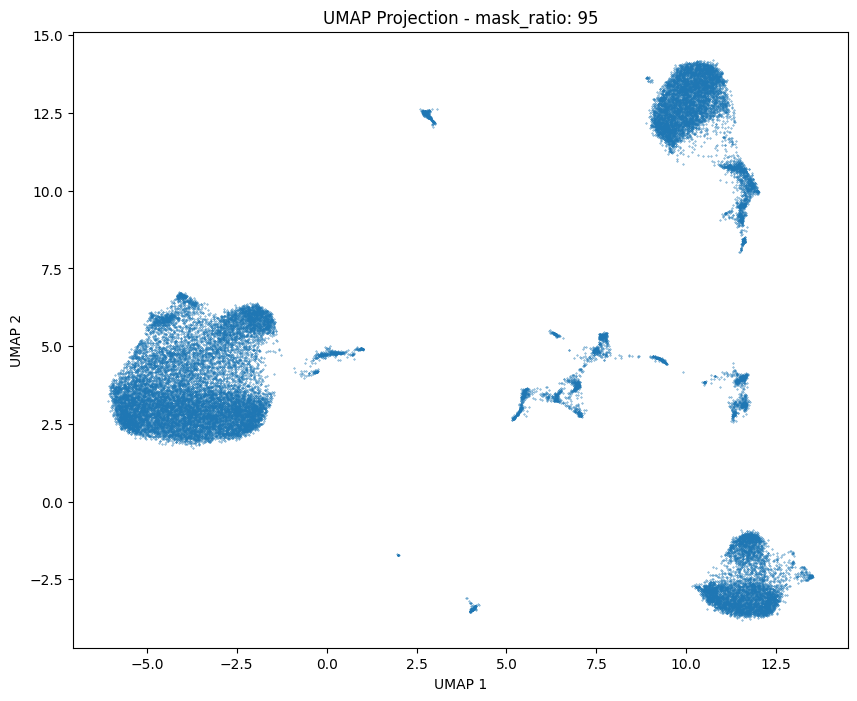

In [23]:
# check the umap visualization when alpha=0.1 to alpha=0.9
for mask_ratio in range(15, 100, 10):
    trainer = Trainer( 
        training_data,
        model_choice=model_choice,
        rna_input_dim=rna_input_dim,
        prot_input_dim=prot_input_dim,
        hidden_dim=hidden_dim,
        embedding_dim=embedding_dim,
        heads=heads,
        num_blocks=num_blocks,
        batch_size=batch_size,
        lr=lr,
        epochs=epochs,
        mask_ratio=mask_ratio/100,
        permute=False,
        preserve_rate=preserve_rate,
        num_splits=num_splits,
        device=device,
        alpha=0.7,
        beta=beta,
    )
    trainer.train(plot_loss=False)
    embedding = trainer.get_embedding(graph_data)
    UMAP_embedding = reducer.fit_transform(embedding)
    plt.figure(figsize=(10, 8))
    plt.scatter(
        UMAP_embedding[:, 0], UMAP_embedding[:, 1], s=0.1
        )
    plt.title(f"UMAP Projection - mask_ratio: {mask_ratio}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.show()

In [19]:
mdata = mu.MuData({
    "rna": rna_adata_pool,
    "protein": protein_adata_intersect,
})
mdata

MuData object with n_obs × n_vars = 32648 × 13663
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

## With whole transcriptomics

In [3]:
mdata = mu.read_h5mu(f"{save_path}scCITE_combine.h5mu")
mdata

MuData object with n_obs × n_vars = 32648 × 13760
  2 modalities
    rna:	32648 x 13553
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 207
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [4]:
mdata.update()

In [5]:
gene_dict = {
    "Atn1-1": "Atn1",
    "Dancr-1": "Dancr",
    "Gbp6-1": "Gbp6",
    "Hist2h2bb-1": "Hist2h2bb",
    "Itgam-1": "Itgam",
    "Pcdhga8-1": "Pcdhga8",
    "Smim20-1": "Smim20",
    "U2af1l4-1": "U2af1l4",
}

In [6]:
# replace var_names using gene_dict
for k, v in gene_dict.items():
    mdata.mod['rna'].var_names = mdata.mod['rna'].var_names.str.replace(k, v)

In [7]:
# find the repeated gene names and only keep the first one
gene_names = mdata.mod['rna'].var_names
gene_names = pd.Series(gene_names)
# gene_names[gene_names.duplicated(keep=False)]
gene_names = gene_names[~gene_names.duplicated(keep='first')]
gene_names

0                Mrpl15
1                Lypla1
2                 Tcea1
3               Atp6v1h
4                Rb1cc1
              ...      
13548        AC125149.3
13549        AC168977.1
13550              PISD
13551             DHRSX
13552    CAAA01147332.1
Name: index, Length: 13548, dtype: object

In [8]:
mdata.mod["rna"] = mdata.mod['rna'][:, gene_names.index]
mdata

MuData object with n_obs × n_vars = 32648 × 13760
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 207
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'
      layers:	'counts'

In [11]:
gtf_path = "/DATA/User/wuxinchao/st_cite_data/ref/Mus_musculus.GRCm38.84.gtf"
geneVocab = GeneVocab(mdata.mod['rna'])
geneVocab.sort_by_genomic_position(gtf_path)
sc_rna_data = geneVocab.align_features(mdata.mod['rna'])
sc_prot_data = mdata.mod['protein'][mdata.mod['rna'].obs_names]
sc_rna_data.obsp = mdata.mod['rna'].obsp
# sc_prot_data.var_names = sc_prot_data.var_names.str.split("_").str[-2]

In [12]:
model_choice = "Graph Cross Attention"

rna_input_dim = sc_rna_data.X.shape[1]
prot_input_dim = sc_prot_data.X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

scData = SinglecellData(mdata, geneVocab)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData.data)

In [13]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=20,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 146.27597 val_loss: 24.06301
Epoch 2/20 train_loss: 53.28050 val_loss: 12.31422
Epoch 3/20 train_loss: 31.94877 val_loss: 9.76670
Epoch 4/20 train_loss: 28.22417 val_loss: 9.54354
Epoch 5/20 train_loss: 27.86188 val_loss: 9.51136
Epoch 6/20 train_loss: 27.74926 val_loss: 9.46362
Epoch 7/20 train_loss: 27.54523 val_loss: 9.35885
Epoch 8/20 train_loss: 27.19448 val_loss: 9.23387
Epoch 9/20 train_loss: 26.56117 val_loss: 8.97669
Epoch 10/20 train_loss: 25.77815 val_loss: 8.75822
Epoch 11/20 train_loss: 25.16904 val_loss: 8.57291
Epoch 12/20 train_loss: 24.70059 val_loss: 8.45274
Epoch 13/20 train_loss: 24.32517 val_loss: 8.37154
Epoch 14/20 train_loss: 24.11567 val_loss: 8.31517
Epoch 15/20 train_loss: 23.90126 val_loss: 8.26958
Epoch 16/20 train_loss: 23.76920 val_loss: 8.21635
Epoch 17/20 train_loss: 23.62305 val_loss: 8.15923
Epoch 18/20 train_loss: 23.50937 val_loss: 8.13411
Epoch 19/20 train_loss: 23.42136 val_loss: 8.11693
Epoch 20/20 train_loss: 23.29162 val_

In [14]:
# plot the training and validation loss
plt.figure(figsize=(6,6))
plt.plot(train_losses[0], label="train")
plt.plot(val_losses[0], label="validation")
plt.title("Whole transcriptomics and union protein loss decline", fontsize=24)
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16, 'weight': 'normal'}, handlelength=3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("scCITE_whole_trans_training_union_loss.png")

In [15]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/scCITE_seq_whole_union.pt")

In [16]:
model = trainer.best_model

In [17]:
adj_mtx = rna_adata_pool_subset.obsp['connectivities'].toarray()
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((sc_rna_data.X, sc_prot_data.X), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

NameError: name 'rna_adata_pool_subset' is not defined

In [ ]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [122]:
from scipy.sparse import csr_matrix, save_npz

rna_recon = csr_matrix(rna_recon)
prot_recon = csr_matrix(prot_recon)
save_npz("../data/GraphCrossRNArecon_combined_whole_trans_intersect_SLN_scCITE.npz", rna_recon)
save_npz("../data/GraphCrossPorteinrecon_combined_whole_trans_intersect_SLN_scCITE.npz", prot_recon)
# np.save("../data/GraphCrossRNArecon_combined_intersect_SLN_scCITE.npy", rna_recon)
# np.save("../data/GraphCrossPorteinrecon_combined_intersect_SLN_scCITE.npy", prot_recon)

In [ ]:
np.save("../data/GraphCrossEmbedding_combined_whole_trans_union_SLN_scCITE.npy", embedding)

In [125]:
mdata

MuData object with n_obs × n_vars = 32648 × 13658
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

# spatial

## spCITE spleen mouse

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import scvi

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
mdata = mu.read_h5mu("/home/wuxinchao/data/st_cite_data/spatial_cite_data/mouse_spleen_spCITE.h5mu")

In [3]:
rna_adata = mdata.mod['rna']
prot_adata = mdata.mod["prot"]

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


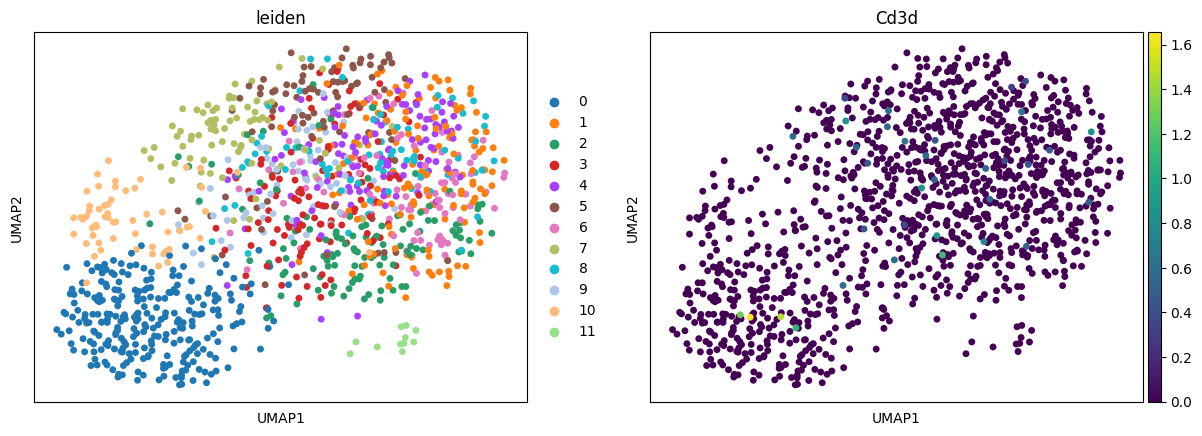

In [149]:
rna_adata.layers["counts"] = rna_adata.X.copy()
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
rna_adata.obs_names_make_unique()

sc.pp.highly_variable_genes(
    rna_adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    # batch_key="batch",
    layer="counts",
)
rna_adata.raw = rna_adata
sc.pp.scale(rna_adata, max_value=10)
sc.tl.pca(rna_adata, svd_solver='arpack')
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=50)

sc.tl.leiden(rna_adata, resolution=1)
sc.tl.umap(rna_adata, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna_adata, color=['leiden','Cd3d'])

In [147]:
# int(rna_adata.obs["x"]), int(rna_adata.obs["y"])
rna_adata.obs["x"] = rna_adata.obs["x"].astype(float)
rna_adata.obs["y"] = rna_adata.obs["y"].astype(float)
rna_adata.obsm["spatial"] = rna_adata.obs[["x", "y"]].values

In [154]:
prot_adata.obs[["x", "y"]] = rna_adata.obs[["x", "y"]]

In [155]:
prot_adata.obs["x"] = prot_adata.obs["x"].astype(float)
prot_adata.obs["y"] = prot_adata.obs["y"].astype(float)
prot_adata.obsm["spatial"] = prot_adata.obs[["x", "y"]].values

In [283]:
mdata.write("/home/wuxinchao/data/st_cite_data/spatial_cite_data/mouse_spleen_spCITE.h5mu")

In [7]:
highly_variable = pd.read_csv(f"{save_path}/scCITE_hvg.csv")

In [8]:
# rna_adata[:,highly_variable.iloc[:,0]]
rna_adata_hvg_transfer = rna_adata[:, rna_adata.var_names.isin(highly_variable.iloc[:,0].to_list())]
rna_adata_hvg_transfer

View of AnnData object with n_obs × n_vars = 1222 × 3210
    obs: 'n_genes', 'x', 'y', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_proximity'

In [9]:
# new_exp = np.zeros_like((rna_adata_hvg_transfer.shape[0], len(highly_variable)-1))
highly_variable.index = highly_variable.iloc[:,0]
highly_variable = highly_variable.T
highly_variable = highly_variable.drop('0')

In [10]:
for i, gene_name in enumerate(rna_adata_hvg_transfer.var_names):
    highly_variable[gene_name] = rna_adata_hvg_transfer.X[:,i]
# highly_variable["Akap12"] = rna_adata_hvg_transfer.X[:,2]

In [11]:
highly_variable = highly_variable.fillna(0)

In [12]:
prot_adata.layers["counts"] = prot_adata.X.copy()

In [13]:
prot_adata.X = prot_adata.layers["counts"].copy()
sc.pp.normalize_total(prot_adata, target_sum=1e4)
sc.pp.log1p(prot_adata)

In [14]:
# ''.join(filter(str.isalnum, prot_adata.var_names[prot_adata.var_names.str.contains("CD")].to_list()[0].lower()))
list1 = [i[:-1] for i in protein_adata_intersect.var_names.str.replace("ADT_", "").str.split("_")]
list2 = prot_adata.var_names.to_list()
result = {}
for i, protein1 in enumerate(list1):
    for j, protein2 in enumerate(list2):
        # print(protein1), print(protein2)
        if ''.join(filter(str.isalnum, protein1[0].lower())) in ''.join(filter(str.isalnum, protein2.lower())):
            # result[protein1[0]] = f"index of list 1: {i} (name in list 1: {protein1}), index of list 2: {j} (name in list 2: {protein2})"
            result[protein1[0]] = [i, j]
            break

In [16]:
new_prot_exp = pd.DataFrame(columns = protein_adata_intersect.var_names)
for protein in result:
    new_prot_exp[new_prot_exp.columns[result[protein][0]]] = prot_adata.X[:, result[protein][1]]
new_prot_exp = new_prot_exp.fillna(0)

In [264]:
import numpy as np

# Function to calculate Euclidean distance between two spots
def euclidean_distance(s_i, s_j):
    return np.sqrt((s_i[0] - s_j[0])**2 + (s_i[1] - s_j[1])**2)

# Function to calculate the weight based on the exponential decay function
def exponential_decay(d, alpha):
    return np.exp(-alpha * d)

# Function to build the weighted adjacency matrix
def build_adjacency_matrix(spots, alpha):
    n = len(spots)  # Number of spots
    W = np.zeros((n, n))  # Initialize the adjacency matrix
    
    # Iterate through each pair of spots to fill the adjacency matrix
    for i in range(n):
        for j in range(n):
            if i != j:  # No self-connections
                d = euclidean_distance(spots[i], spots[j])
                W[i, j] = exponential_decay(d, alpha)
    
    return W

In [274]:
rna_adata.obsp["spatial_proximity"] = build_adjacency_matrix(prot_adata.obsm["spatial"], 0.5)

In [17]:
highly_variable.shape, new_prot_exp.shape

((1222, 4000), (1222, 110))

In [18]:
rna_input = highly_variable.values[:, :-1]
prot_input = new_prot_exp.values

In [52]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_input.shape[1]
prot_input_dim = prot_input.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = rna_adata.obsp['spatial_proximity']
edge_index = adj_mtx.nonzero()
edge_index = np.array(edge_index)
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous().to(device)
concat_data = np.concatenate((rna_input, prot_input), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 1
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [73]:
scData

Data(x=[1222, 4109], edge_index=[2, 1492062], train_mask=[1222], val_mask=[1222], test_mask=[1222])

In [20]:
# loading the pre-trained model
from model import GraphCrossAttn

model = GraphCrossAttn(
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
).to(device)

# load the pre-trained model
# model.load_state_dict(torch.load("../save_model/scCITE_intersect_hvg.pt")["model"])

<All keys matched successfully>

In [53]:
training_data

Data(x=[1222, 4109], edge_index=[2, 1492062], train_mask=[1222], val_mask=[1222], test_mask=[1222])

In [60]:
import importlib
import sys

importlib.reload(sys.modules['train'])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [63]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.75,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses = trainer.fine_tune(model=model, epochs=10, 
                    model_name="scCITE_intersect_hvg.pt", save_name="sc_spCITE_spleen_mouse_transfer.pt")

Epoch 1/10, Loss: 3.179643233617147
Epoch 2/10, Loss: 2.289055426915487
Epoch 3/10, Loss: 1.7865444421768188
Epoch 4/10, Loss: 1.7076302766799927
Epoch 5/10, Loss: 1.694178581237793
Epoch 6/10, Loss: 1.6648138761520386
Epoch 7/10, Loss: 1.6124885082244873
Epoch 8/10, Loss: 1.5646273692448933
Epoch 9/10, Loss: 1.5310066143671672
Epoch 10/10, Loss: 1.5077422857284546


In [64]:
model.load_state_dict(torch.load("../save_model/best_sc_spCITE_spleen_mouse_transfer.pt")["model"])

<All keys matched successfully>

In [65]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [97]:
# df.DataFrame(mdata.mod['rna'].var[mdata.mod['rna'].var["highly_variable"]].index).to_csv("../data/scCITE_combined_hvg_list.csv")

In [67]:
np.save("../data/GraphCrossRNArecon_intersect_hvg_mouse_spleen_spCITE.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_intersect_hvg_mouse_spleen_spCITE.npy", prot_recon)

In [68]:
np.save("../data/GraphCrossEmbedding_intersect_hvg_mouse_spleen_sp.npy", embedding)

### sp integrate

In [75]:
rna_adata, prot_adata

(AnnData object with n_obs × n_vars = 1222 × 16033
     obs: 'n_genes', 'x', 'y', 'leiden'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
     uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'connectivities', 'distances', 'spatial_proximity',
 AnnData object with n_obs × n_vars = 1222 × 193
     obs: 'n_genes', 'x', 'y'
     var: 'n_cells'
     uns: 'log1p'
     obsm: 'spatial'
     layers: 'counts')

In [77]:
rna_adata_subset = rna_adata[:,rna_adata.var['highly_variable']]
rna_adata_subset

View of AnnData object with n_obs × n_vars = 1222 × 4000
    obs: 'n_genes', 'x', 'y', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances', 'spatial_proximity'

In [78]:
rna_input = rna_adata_subset.X
prot_input = prot_adata.X

In [81]:
import torch

def build_adjacency_matrix_torch(spots, alpha, T=0.005, device='cuda'):
    spots = torch.tensor(spots, dtype=torch.float32, device=device)
    # Calculate the pairwise Euclidean distances using broadcasting
    diff = spots[:, None, :] - spots[None, :, :]
    distances = torch.sqrt(torch.sum(diff**2, dim=-1))
    
    # Apply the exponential decay function to the distances
    W = torch.exp(-alpha * distances)
    W.masked_fill_(W<T, 0)
    
    # Zero out the diagonal (no self-connections)
    W.fill_diagonal_(0)
    
    return W

In [85]:
model_choice = "Graph Cross Attention"

rna_input_dim = rna_input.shape[1]
prot_input_dim = prot_input.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_adata_subset.obsm["spatial"], alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_input, prot_input), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.2
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [88]:
import importlib
import sys

importlib.reload(sys.modules["train"])

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [89]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=mask_ratio,
    permute=permute,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()
# 32s

Epoch 1/20 train_loss: 22.51069 val_loss: 7.36853
Epoch 2/20 train_loss: 21.97413 val_loss: 7.06932
Epoch 3/20 train_loss: 21.05295 val_loss: 6.61205
Epoch 4/20 train_loss: 19.60207 val_loss: 5.93934
Epoch 5/20 train_loss: 17.62378 val_loss: 5.24630
Epoch 6/20 train_loss: 15.58553 val_loss: 4.71480
Epoch 7/20 train_loss: 13.69946 val_loss: 4.11663
Epoch 8/20 train_loss: 11.90050 val_loss: 3.55900
Epoch 9/20 train_loss: 10.36113 val_loss: 3.14705
Epoch 10/20 train_loss: 9.05988 val_loss: 2.82881
Epoch 11/20 train_loss: 8.09120 val_loss: 2.57403
Epoch 12/20 train_loss: 7.42407 val_loss: 2.38125
Epoch 13/20 train_loss: 6.94001 val_loss: 2.25360
Epoch 14/20 train_loss: 6.57417 val_loss: 2.17295
Epoch 15/20 train_loss: 6.32847 val_loss: 2.10913
Epoch 16/20 train_loss: 6.17013 val_loss: 2.08335
Epoch 17/20 train_loss: 6.06612 val_loss: 2.05556
Epoch 18/20 train_loss: 6.00650 val_loss: 2.03090
Epoch 19/20 train_loss: 5.93739 val_loss: 2.01970
Epoch 20/20 train_loss: 5.87652 val_loss: 2.01176


In [90]:
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/spCITE_seq_integrate.pt")

In [92]:
# model.load_state_dict(torch.load("../save_model/spCITE_seq_integrate.pt")["model"])
model = trainer.best_model

In [93]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [94]:
np.save("../data/GraphCrossRNArecon_human_thymus_spCITE_hvg.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_human_thymus_spCITE_hvg.npy", prot_recon)
np.save("../data/GraphCrossEmbedding_human_thymus_spCITE_hvg.npy", embedding)

In [96]:
%whos

Variable                       Type               Data/Info
-----------------------------------------------------------
Data                           type               <class 'torch_geometric.data.data.Data'>
GeneVocab                      type               <class 'dataset.GeneVocab'>
GraphCrossAttn                 type               <class 'model.GraphCrossAttn'>
RandomNodeSplit                ABCMeta            <class 'torch_geometric.t<...>e_split.RandomNodeSplit'>
SinglecellData                 type               <class 'dataset.SinglecellData'>
Trainer                        type               <class 'train.Trainer'>
ad                             module             <module 'anndata' from '/<...>ges/anndata/__init__.py'>
adj_mtx                        Tensor             tensor([[0.0000, 0.0000, <...>\n       device='cuda:0')
alpha                          float              0.4
batch_size                     int                256
beta                           float           